In [1]:
import numpy as np
from data_preperation.dataset import CityDataset
import os

from config import PATH, CITIES, TEST_CITY, MIN_LABELS, PATCH_SIZE
PATH

'data'

# Plot Test Data

Profile:
	 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 1427, 'height': 1361, 'count': 6, 'crs': CRS.from_epsg(32633), 'transform': Affine(10.0, 0.0, 384100.0,
       0.0, -10.0, 5826300.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
SHAPE:		 (1361, 1427)
dtype		 int16
max		 10608
min		 98
mean		 772.9615595523923
std		 477.7241897203279
sum		 1501204974
Profile:
	 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 1427, 'height': 1361, 'count': 1, 'crs': CRS.from_epsg(32633), 'transform': Affine(10.0, 0.0, 384100.0,
       0.0, -10.0, 5826300.0), 'blockysize': 2, 'tiled': False, 'interleave': 'band'}
SHAPE:		 (1361, 1427)
dtype		 int16
max		 1
min		 0
mean		 0.40552491649705197
std		 0.4909933386484089
sum		 787589
p_down, p_up [200. 296. 232. 288. 219. 313.] [2545. 2351. 2146. 4188. 2732. 3103.]


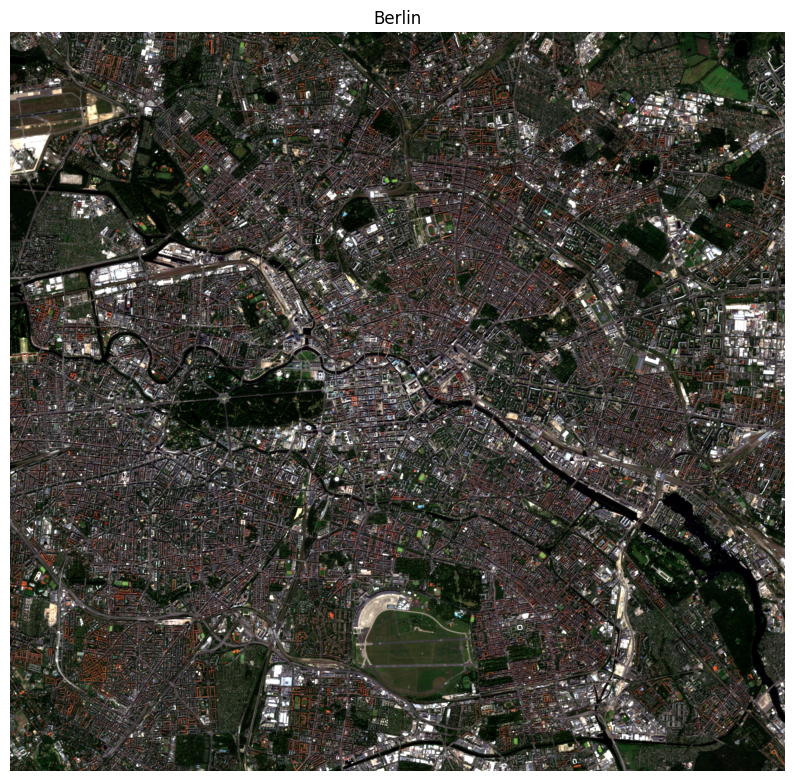

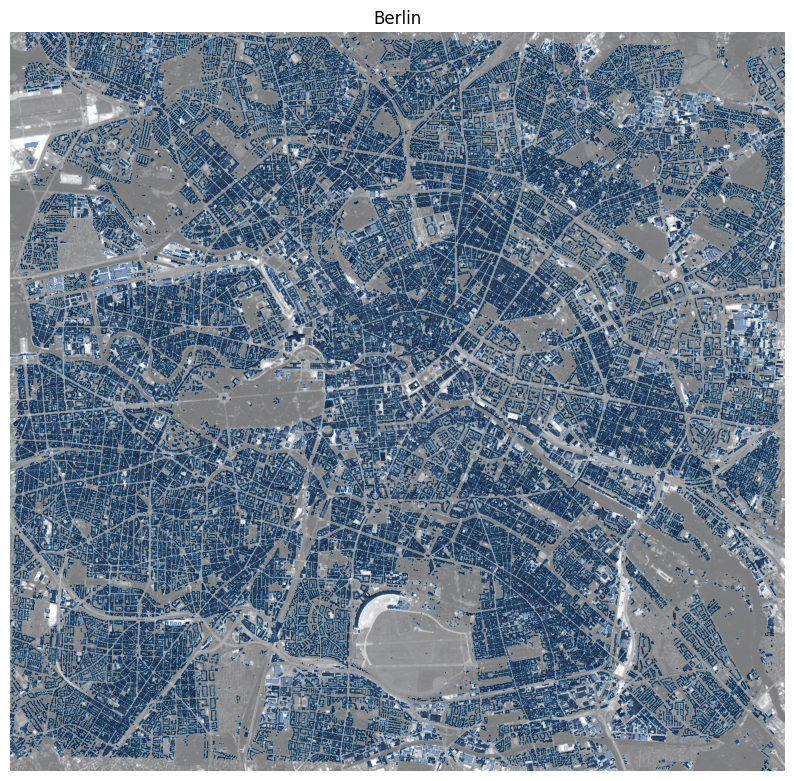

In [2]:
# check if the mask is correct
import rasterio
from utilities.plot_utils import (
    plot_band_with_mask,
    histogram_scaler_bands,
    describe_tif,
    plot_bands,
)

b = {
    "B04": 0,
    "B03": 1,
    "B02": 2,
    "B08": 3,
    "B12": 4,
    "B11": 5,
}

with rasterio.open(
    os.path.join(PATH,"Berlin/openEO.tif")
) as src:
    describe_tif(src)
    data = src.read([1, 2, 3, 4, 5, 6])
with rasterio.open(
    os.path.join(
        PATH, "Berlin/building_mask_dense.tif")
) as src:
    describe_tif(src)
    labels = src.read(1)

data = histogram_scaler_bands(data, 1.0, 99.0)

plot_bands(data, bands=[b["B04"], b["B03"], b["B02"]], title="Berlin")
plot_band_with_mask(data[b["B04"]], labels, title="Berlin")

In [4]:

dataset = CityDataset(
    PATH,
    patch_size=PATCH_SIZE,
    data_name="openEO.tif",
    labels_name="building_mask_dense.tif",
    image_bands=[1, 2, 3, 4, 5, 6],
    min_labels=MIN_LABELS,
    cities=CITIES,
    train=True,
)

dataset_test = CityDataset(
    PATH,
    data_name="openEO.tif",
    labels_name="building_mask_dense.tif",
    image_bands=[1, 2, 3, 4, 5, 6],
    cities=TEST_CITY,
    train=False,
)

Loading data from cities:
['Singapore', 'Johannesburg', 'Bogota', 'Wien', 'London', 'Montreal', 'Seoul', 'Aachen', 'CapeTown', 'Hamburg', 'Paris', 'Frankfurt', 'Muenchen', 'Sydney']


Loading Images:   0%|          | 0/14 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/14 [00:00<?, ?it/s]

Creating Patches from Images: 0it [00:00, ?it/s]

Loading data from cities:
['Berlin']


Loading Images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/1 [00:00<?, ?it/s]

# No Hyperparam Tuning

In [5]:
# it is possible to update the patch size without reloading the dataset
dataset.update_patch_size(32)  # 32x32 patches

Creating Patches from Images: 0it [00:00, ?it/s]

In [6]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import lightning as L
from typing import Any
from torch.utils.data import DataLoader, Dataset
from lightning import seed_everything


# batch size 8 with 16x16 patches GPU memory: 36%, 117 it/s
# batch size 16 with 16x16 patches GPU memory: 37%, 117 it/s
# batch size 32 with 16x16 patches GPU memory: 40%, 90 it/s
batch_size = 32

train_dataset, val_dataset = dataset.train_val_split(
    val_size=0.1, n_groups=100, random_state=42, show_summary=True
)
train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=20
)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=20)


print(f"Len total dataset: {len(dataset)}")
print(f"len train dataset: {len(train_dataset)}")
print(f"len val dataset: {len(val_dataset)}")

sample_train = next(iter(train_dl))
sample_val = next(iter(val_dl))
print(
    "Training Sample (data, labels)",
    sample_train["data"].shape,
    sample_train["labels"].shape,
)
print(
    "Validation Sample (data, labels)",
    sample_val["data"].shape,
    sample_val["labels"].shape,
)
print("Len train", len(train_dl))
print("Len val", len(val_dl))

Train:
Number of samples: 60831
Shape of Train data (data, label) (6, 32, 32) (1, 32, 32)
Val:
Number of samples: 6760
Shape of Val data (data, label) (6, 32, 32) (1, 32, 32)
**************************************************
Mean percentage of 1 labels in train: 0.36058565752350774
Mean percentage of 1 labels in val: 0.3609503571098373
Mean percentage of 1 labels in all data: 0.3606221323382551
**************************************************
Std of percentage 1 labels in train: 0.1866838755360914
Std of percentage 1 labels in val: 0.18706995439620863
Std of percentage 1 labels in all data: 0.18672255654784756
**************************************************
Min percentage of 1 labels in train: 0.1005859375
Min percentage of 1 labels in val: 0.1005859375
Min percentage of 1 labels in all data: 0.1005859375
**************************************************
Max percentage of 1 labels in train: 0.98828125
Max percentage of 1 labels in val: 1.0
Max percentage of 1 labels in all data:

In [ ]:
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=20)
sample_test = next(iter(test_dl))
print(sample_test["data"].shape, sample_test["labels"].shape)

# Load Model

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from models.lightning_utils import LitModule
from models.baseconvnet import ConvNetSimple

# model
convmodel = LitModule(ConvNetSimple(channels=6))


# trainer
def get_trainer(directory):
    trainer = L.Trainer(
        default_root_dir=f"model_experiments/exp01/{directory}",
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                mode="min",
                patience=2,
            ),
            ModelCheckpoint(
                monitor="val_loss",
                mode="min",
                save_top_k=2,
                dirpath=f"model_experiments/exp01/{directory}",
                filename="best_model",
            ),
        ],
        # val_check_interval=1,
        fast_dev_run=False,
        num_sanity_val_steps=2,
        max_epochs=100,
        log_every_n_steps=20,
    )
    return trainer

### Tune LR

In [ ]:
from lightning.pytorch.tuner.tuning import Tuner

In [ ]:
trainer = get_trainer("ConvNetSimple")

seed_everything(49)
tuner = Tuner(trainer=trainer)
torch.set_float32_matmul_precision("high")  # for tensor cores

tuner.lr_find(convmodel, train_dl, val_dl, min_lr=1e-6, max_lr=0.01, num_training=5000)

# good lr: 0.001174897554939528

# Train Model

In [ ]:
# # training
trainer.fit(convmodel, train_dataloaders=train_dl, val_dataloaders=val_dl)

In [ ]:
best_model_conv = LitModule.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trainer.test(model=best_model_conv, dataloaders=test_dl)

In [ ]:
# plot the output of the test
import matplotlib.pyplot as plt

sample = next(iter(test_dl))
print(f"Sample shape: {sample['data'].shape}")
# convmodel.eval()
# output = convmodel(sample["data"])
# print(output.shape)

prediction = trainer.predict(model=best_model_conv, dataloaders=test_dl)

In [ ]:
print(prediction[0].shape)
output = prediction[0].detach().numpy()
output = output.squeeze()
print(output.shape)
# output

In [ ]:
from utilities.plot_utils import (
    plot_prediction_with_thresholds,
    plot_random_patch,
    plot_output,
)

plot_output(output)
plot_random_patch(output, patch_len=6)
plot_prediction_with_thresholds(output)

# Model U-Net

In [ ]:
# import torchmetrics
# from torchmetrics import Dice
from models.unet import UNet

# model
unet = UNet(n_channels=len(dataset.get_image_bands()), n_classes=1, bilinear=True)


# UNet implementation uses the BCEWithLogitsLoss, lr of 1e-5 default
unet_lit = LitModule(unet, learning_rate=1e-4, loss=nn.BCEWithLogitsLoss())

torch.set_float32_matmul_precision("high")
unet_trainer = get_trainer("unet")

seed_everything(49)
# lr finder
tuner = Tuner(unet_trainer)
tuner.lr_find(unet_lit, train_dl, val_dl, min_lr=1e-6, max_lr=0.01, num_training=5000)
# good lr: 0.0031915378551007614

unet_trainer.fit(unet_lit, train_dataloaders=train_dl, val_dataloaders=val_dl)

In [ ]:
best_model = LitModule.load_from_checkpoint(
    unet_trainer.checkpoint_callback.best_model_path
)
unet_trainer.test(model=best_model, dataloaders=test_dl)

In [ ]:
# unet_trainer.test(model=unet_lit, dataloaders=test_dl)

In [ ]:
prediction = unet_trainer.predict(model=best_model, dataloaders=test_dl)
# prediction = unet_trainer.predict(model=unet_lit, dataloaders=test_dl)
print(prediction[0].shape)
# prediction = F.interpolate(prediction[0], (output.shape[2], output.shape[3]), mode="bilinear")


output = torch.sigmoid(prediction[0]).detach().numpy()
# output = prediction[0].detach().numpy()
print(output.shape)
output = output.squeeze()
print(output.shape)
# output
plot_output(output)
plot_random_patch(output, patch_len=6)
plot_prediction_with_thresholds(output)